# Single map correction MC

## Scope 

- This NB computes XY maps using MC data to correct energy and
lifetime.



##### Author:  JJGC

##### Software: KrCalib : https://github.com/nextic/ICAROS/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
import glob
print("Last updated on ", time.asctime())

Last updated on  Fri Feb 22 19:23:18 2019


##### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-02-22 19:23:18,183 | INFO : Hello world!


# Input files

In [3]:
from krcal.core.kr_types import KrFileName
# input_path  = f"$IC_DATA/dst"
# output_path = f"$IC_DATA/ldst"
input_path  = f"/Users/pabloherrero/ic/data/mc/kr/kdst/"
output_path = f"/Users/pabloherrero/ic/data"
map_path    = f"/Users/pabloherrero/ic/data/maps"

input_file_names  = "Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4*.h5"

filenames = "".join([input_path, input_file_names])
input_dst_filenames  = glob.glob(os.path.expandvars(filenames))

time_bins = 1
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_50_50_mc.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

## Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import data_frames_are_identical

from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

from krcal.core.kr_types            import PlotLabels, FitType

from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [16]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

import krcal.dev.corrections       as corrections 


In [21]:
from numpy import pi, sqrt

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [22]:
import logging
log = logging.getLogger()

## Input/output 

In [23]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [25]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [26]:
unique_events = ~dst.event.duplicated()
number_of_evts = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 901784


In [27]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [28]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 15000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [29]:
krRanges

KrRanges(S2e=(2000, 14000), S1e=(3, 25), S2q=(200, 800), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(0, 901784))

In [30]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=50, Y=50, Z=15, T=250)

### Sort DST in time and add DT column (DT is a vector of time differences)

In [31]:
T       = np.arange(len(dst))
DT      = time_delta_from_time(T)

In [32]:
dst = dst.assign(DT=DT)

In [33]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

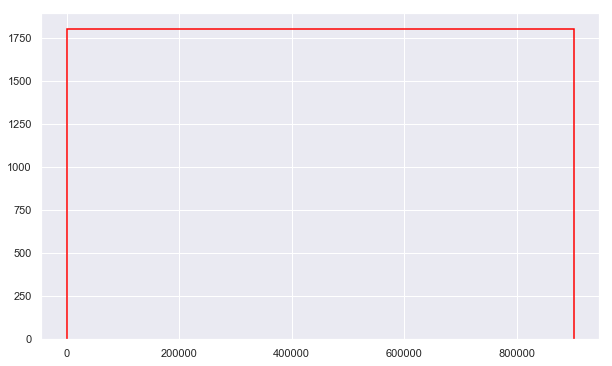

In [34]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.DT.values, bins=500, range = (dst.DT.values[0], dst.DT.values[-1]), color='red', stats=False, lbl='pre-sel')

#### NB: Variable rate from Krypton

### Time 

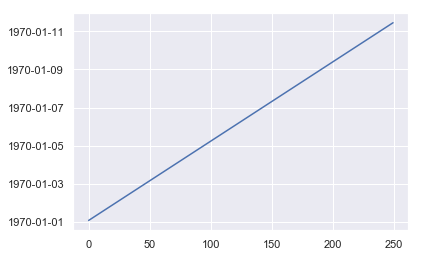

In [35]:
plt.plot(krTimes.timeStamps)

## Fiducial cut

In [36]:
dst = dst[in_range(dst.R, 0, RMAX)]

# Event distribution

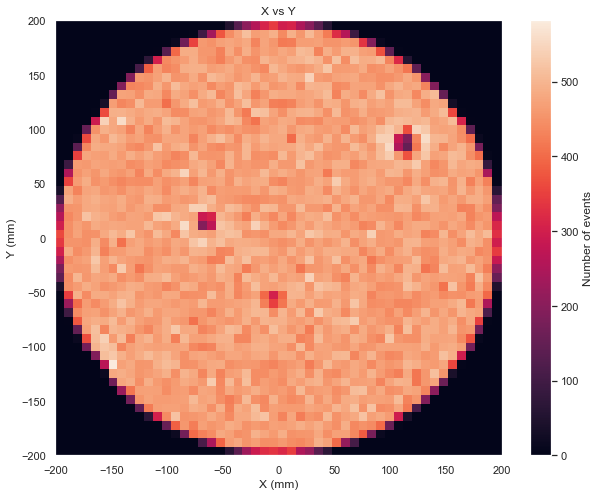

In [115]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Fit lifetime of the time series in the fiducial volume ( R < 180 cm) 

In [38]:
dstfid = dst[in_range(dst.R, 0, RFID)]

## Time series

In [39]:
ti = timeit(get_time_series_df)
ts, masks = ti(time_bins, (DT[0],DT[-1]), dstfid)

Time spent in get_time_series_df: 0.0036139488220214844 s


In [112]:
ti = timeit(time_fcs_df)
fps = ti(ts, masks, dstfid, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         z       = 'Z',
         fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

Time spent in time_fcs_df: 1.9145042896270752 s


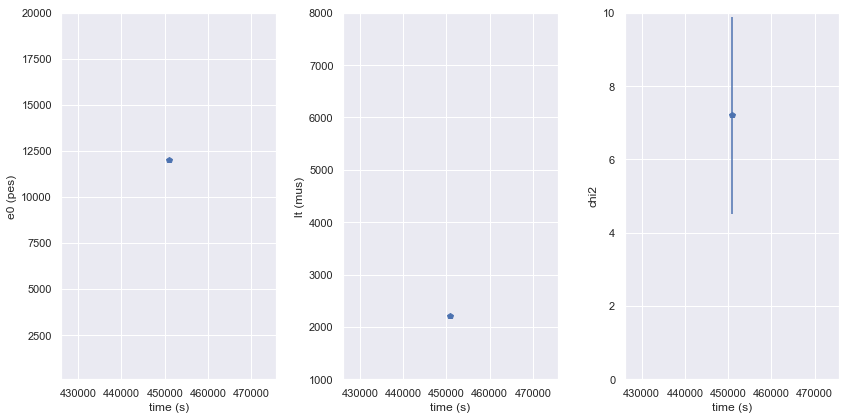

In [113]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (1000, 8000),
              figsize     = (12,6))

# Lifetime in RPhi

##### To compute a RPHI map, the first step is to define a KrSector map which contains the definition of the RPHI wedges:

In [42]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [43]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [44]:
W = define_rphi_sectors(rpsmd)

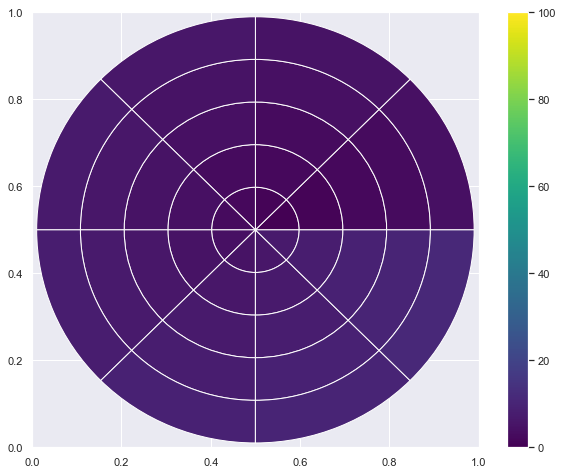

In [45]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

##### The next step is to select the RPHI sectors than enter the map.

In [46]:
ti = timeit(select_rphi_sectors_df)
KSRP = ti(dst, W) # KSRP: Krypton Selection R-PHI

Time spent in select_rphi_sectors_df: 1.5131421089172363 s


In [47]:
ti = timeit(event_map_df)
neM = ti(KSRP)

Time spent in event_map_df: 0.003312826156616211 s


##### The number of events in the map can be represented by a heat map

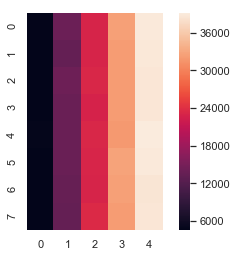

In [48]:
ax = sns.heatmap(neM, square=True)

##### One can now fit the lifetime in RPHI sectors (in time bins)

In [49]:
erange = (0,18000)
ltrange = (0, 3000)
# frs --> fit radial sectors 

Time spent in fit_fcs_in_rphi_sectors_df: 0.11030817031860352 s
Time spent in fit_fcs_in_rphi_sectors_df: 0.1421670913696289 s
Time spent in fit_fcs_in_rphi_sectors_df: 0.14963698387145996 s
Time spent in fit_fcs_in_rphi_sectors_df: 0.23930978775024414 s
Time spent in fit_fcs_in_rphi_sectors_df: 0.2457261085510254 s


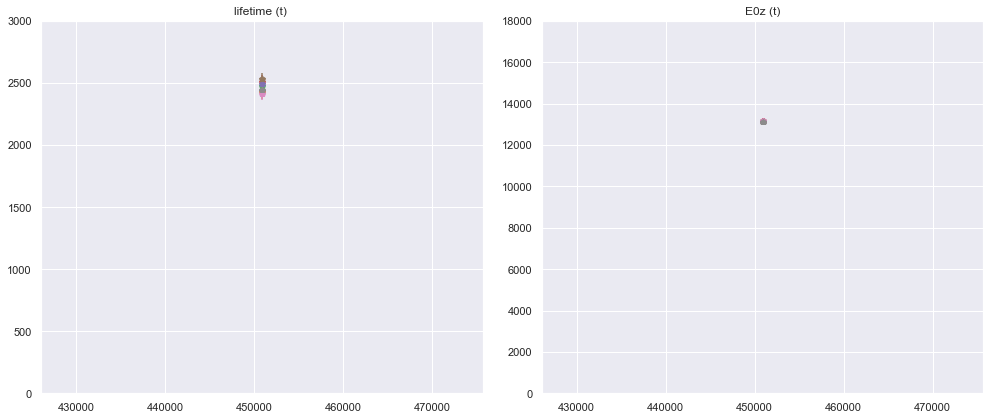

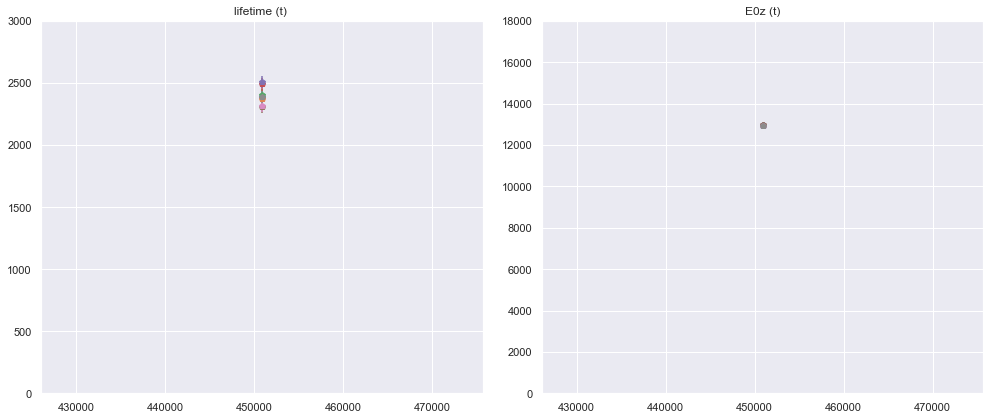

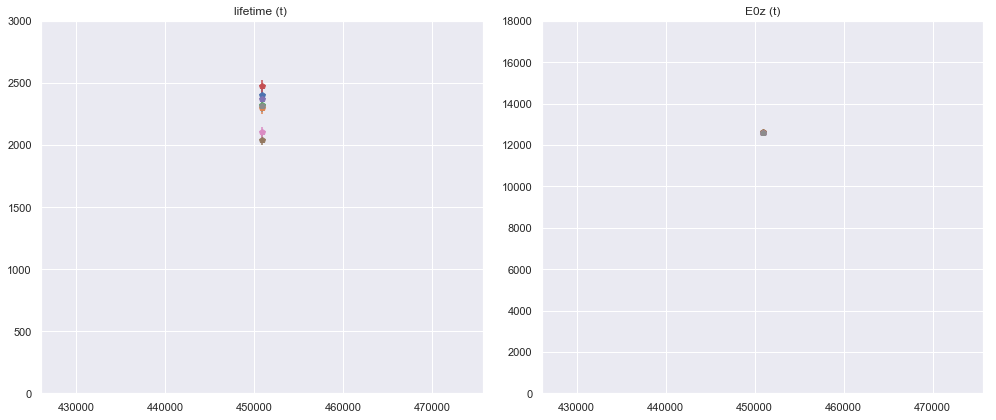

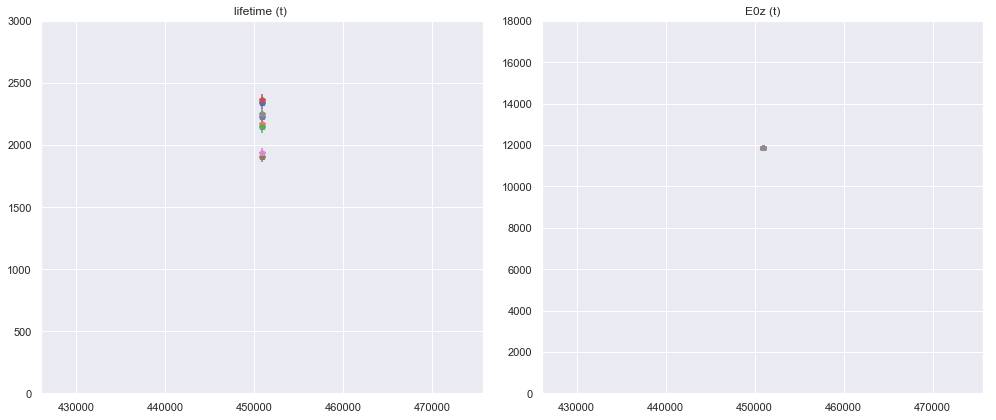

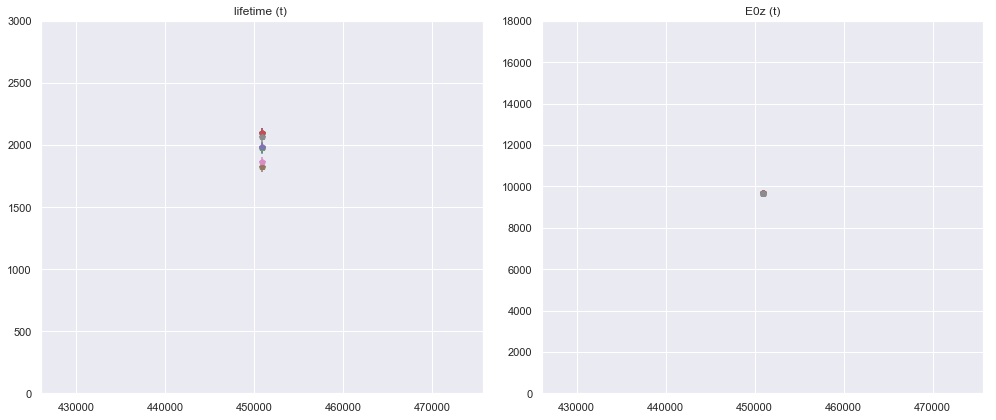

In [50]:
ti = timeit(fit_fcs_in_rphi_sectors_df)
for sector in range(NSECTORS):
    frs2 = ti(sector = sector,
              selection_map = KSRP,
              event_map     = neM,
              n_time_bins   = time_bins,
              time_diffs    = DT,
              nbins_z       = 25,
              nbins_e       = 50,
              range_z       =(50, 550),
              range_e       = (5000, 14500),
              energy        = 'S2e',
              fit           = FitType.unbined,
              n_min         = 100)

    plot_fit_sectors(frs2,  range_e0 =erange, range_lt=ltrange)

## Single time XY map. 

- Compute a single-time (or time-averaged) map, with a fine-grain in XY. 
- The energy map (e0 correction) is invariant and can be added for many maps.
- The lt map (lt correction) represents an average-over-run. A correction function may use such a map or add a time-dependent correction, fitting the time dependence. 

## Divide chamber in sectors of XY

In [51]:
log.setLevel(logging.DEBUG) # turn to DEBUG to follow progress of this part 

In [52]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 5.604067087173462 s


In [53]:
nXY = event_map_df(KXY)

2019-02-22 19:24:30,714 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x1a1cd89c50>
2019-02-22 19:24:30,715 | DEBUG : Using auto colorbar locator on colorbar
2019-02-22 19:24:30,717 | DEBUG : locator: <matplotlib.ticker.MaxNLocator object at 0x1a1cd89c50>
2019-02-22 19:24:30,718 | DEBUG : Setting pcolormesh
2019-02-22 19:24:30,766 | DEBUG : update_title_pos
2019-02-22 19:24:30,830 | DEBUG : update_title_pos
2019-02-22 19:24:30,873 | DEBUG : update_title_pos
2019-02-22 19:24:30,910 | DEBUG : update_title_pos
2019-02-22 19:24:30,931 | DEBUG : update_title_pos
2019-02-22 19:24:30,982 | DEBUG : update_title_pos
2019-02-22 19:24:31,027 | DEBUG : update_title_pos
2019-02-22 19:24:31,065 | DEBUG : update_title_pos
2019-02-22 19:24:31,118 | DEBUG : update_title_pos
2019-02-22 19:24:31,149 | DEBUG : update_title_pos
2019-02-22 19:24:31,170 | DEBUG : update_title_pos
2019-02-22 19:24:31,225 | DEBUG : update_title_pos


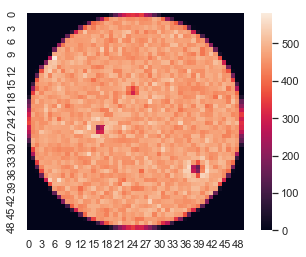

In [54]:
ax = sns.heatmap(nXY, square=True)

In [55]:
log.setLevel(logging.INFO) 

## Fits in XY sectors

# Maps

##### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)

In [114]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy2 = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 15.283633947372437 s


##### The second step is to obtain the maps themselves from the fit-map-XY

In [57]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy2)

Time spent in tsmap_from_fmap: 0.0023550987243652344 s


##### Third step: select the corresponding map in the time series (in this case just one, ts=0)

In [58]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

##### Am contains the maps in XY bins for the single time series (ts=0). We can now compute the map average, draw, etc:

In [59]:
amap_average(am) 

ASectorMap(chi2=1.1956269258801417, e0=11047.097328956163, lt=2160.892174130655, e0u=53.86353972749247, ltu=76.83259283496355, mapinfo=None)

##### Get rid of outlayers that distort mean and error

In [60]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-02-22 19:24:46,556 | INFO :  set nans to average value of interval = 10000.0
2019-02-22 19:24:46,653 | INFO :  set nans to average value of interval = 3500.0


In [61]:
amap_average(rmap)

ASectorMap(chi2=1.1956269258801417, e0=11047.097328956163, lt=2156.254235313609, e0u=53.86353972749247, ltu=74.39797840405303, mapinfo=None)

In [62]:
asm = relative_errors(rmap)

In [63]:
amv = amap_average(asm)
amv

ASectorMap(chi2=1.1956269258801417, e0=11047.097328956163, lt=2156.254235313609, e0u=0.5232991265635474, ltu=3.3843698809669855, mapinfo=None)

### Draw the maps using default colormap

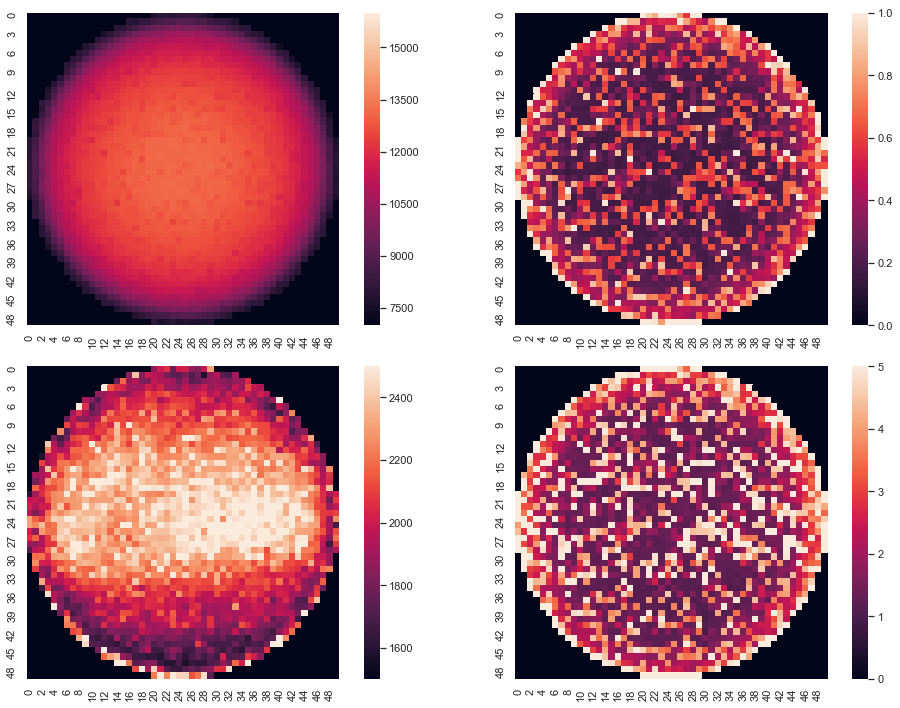

In [64]:
draw_xy_maps(asm,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [65]:
asm.e0.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
           dtype='int64')

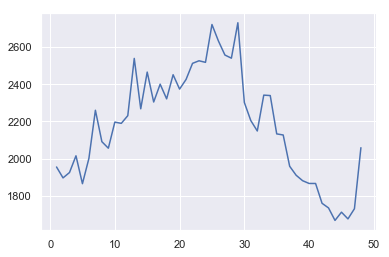

In [66]:
plt.plot(asm.lt[30])

##### The dark spots correspond to regions of low statistic, where the fits did not work. To avoid this effect, it is necessary to use more statistic for the XY maps. 

In [67]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [68]:
amap_average(asmAv)

ASectorMap(chi2=1.1935532541102736, e0=11302.267677515025, lt=2166.9608907447364, e0u=0.4863919725677905, ltu=3.174480787191554, mapinfo=None)

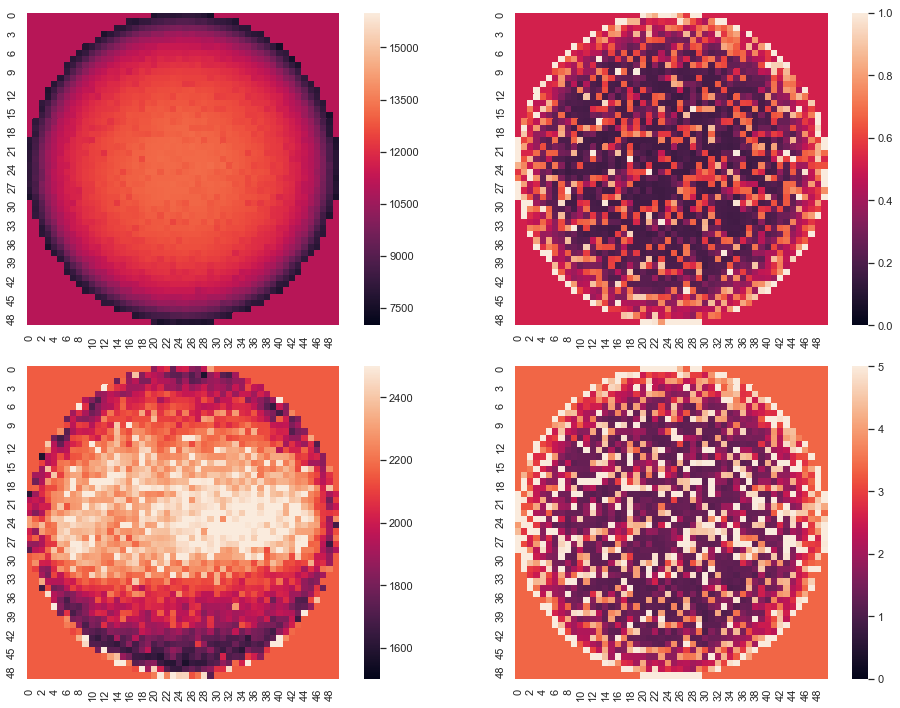

In [69]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

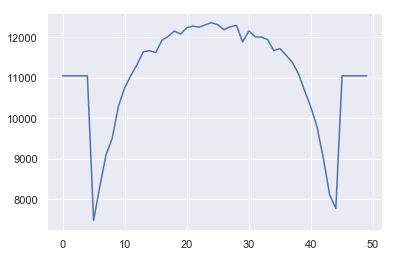

In [70]:
plt.plot(asmAv.e0[40])

In [71]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=-6400)

In [72]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number   -6400
dtype: int64

# Save to file

In [73]:
write_maps(asm, filename=fn.emap_file_name)

## Read back

In [74]:
fn.emap_file_name

'/Users/pabloherrero/ic/data/maps/kr_emap_xy_50_50_mc.h5'

In [75]:
emaps = read_maps(filename=fn.emap_file_name)

In [76]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number   -6400
dtype: int64

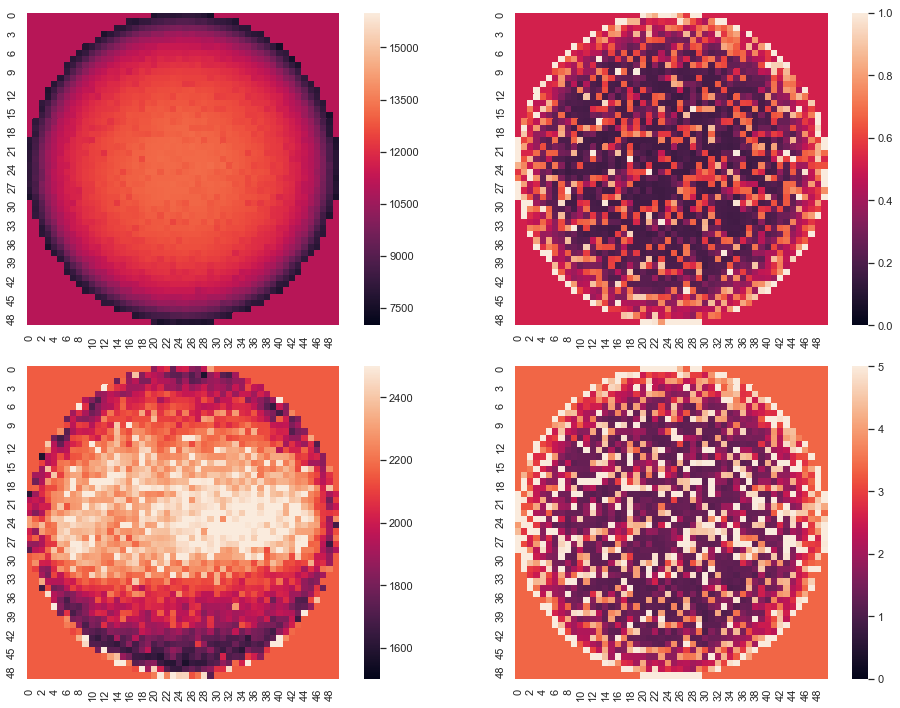

In [77]:
draw_xy_maps(emaps,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

# Now check the corrections that can be achieved with the single maps

In [78]:
amap_average(emaps)

ASectorMap(chi2=1.1935532541102736, e0=11302.267677515025, lt=2166.9608907447364, e0u=0.4863919725677905, ltu=3.174480787191554, mapinfo=None)

In [79]:
norm = amap_max(emaps)

In [80]:
norm

ASectorMap(chi2=5.290650581998757, e0=13237.725510333781, lt=5976.893093094339, e0u=2.926010933483944, ltu=39.75807050883616, mapinfo=None)

## E0 correction:

In [81]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 19.641645908355713 s


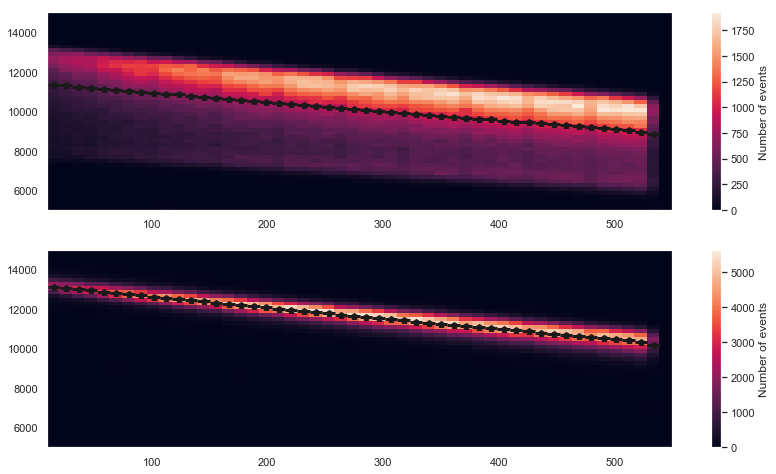

In [82]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

## XY (single time) LT correction

In [83]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 20.43475914001465 s


In [84]:
er = (5000,15000)

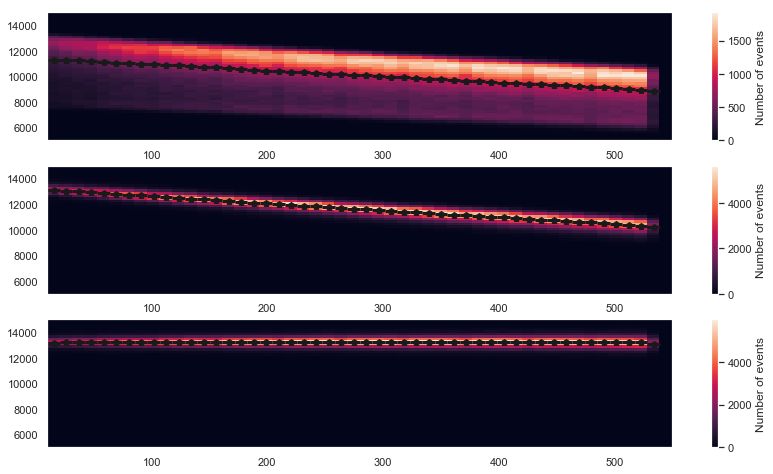

In [85]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

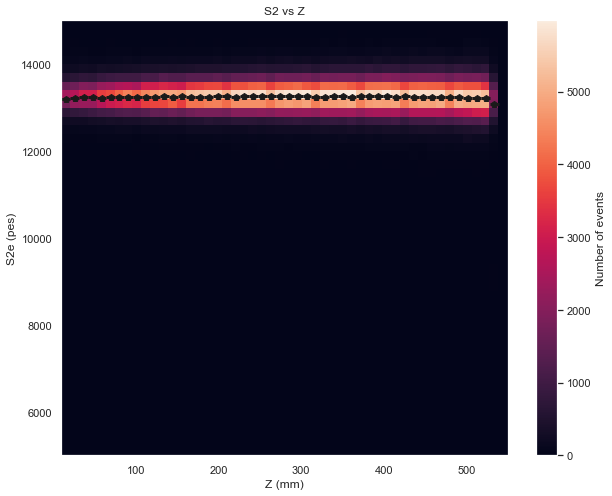

In [86]:
nevt = h2d(dst.Z, E, 50, 50, krRanges.Z, (5000,15000),  
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

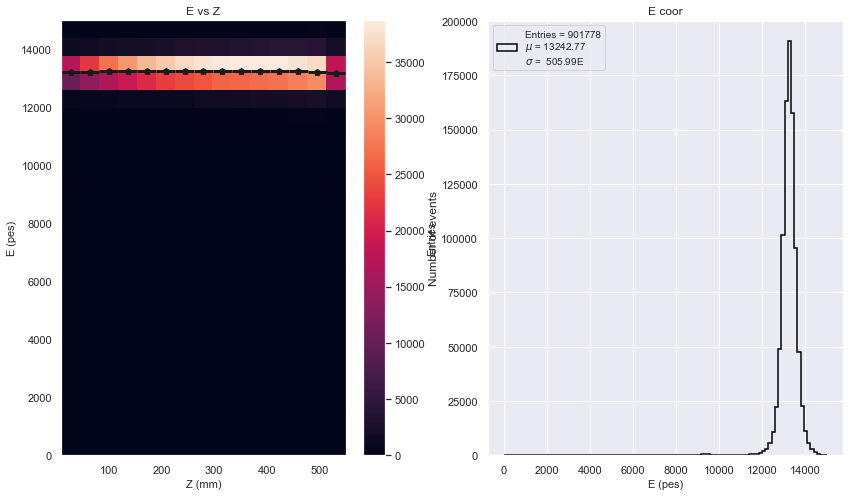

In [87]:
e_range = (0, 15000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 13272.082883366615 +-0.31593310899351684 
 E sigma   = 287.9093674319528 +-0.25970732743956737 
 chi2    = 9.185178421784107 
 sigma E/E (FWHM)     (%) =5.097820887729907
 sigma E/E (FWHM) Qbb (%) =0.6583935407420102 


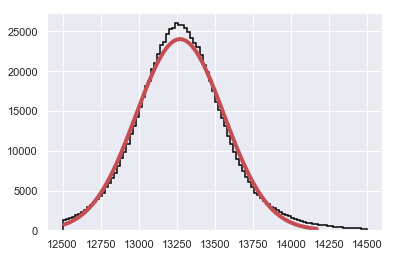

In [88]:
fc = fit_energy(E, nbins=100, range=(12500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

In [89]:
baseline = 12500
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(T, E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),
                    figsize=(12,6))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 901778 but corresponding boolean dimension is 901784

<Figure size 864x432 with 0 Axes>

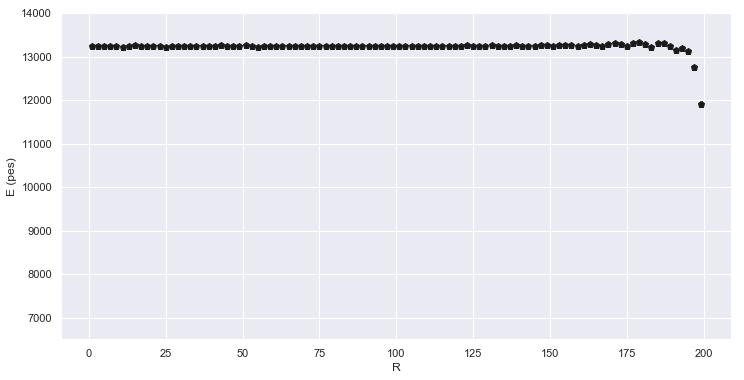

In [90]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

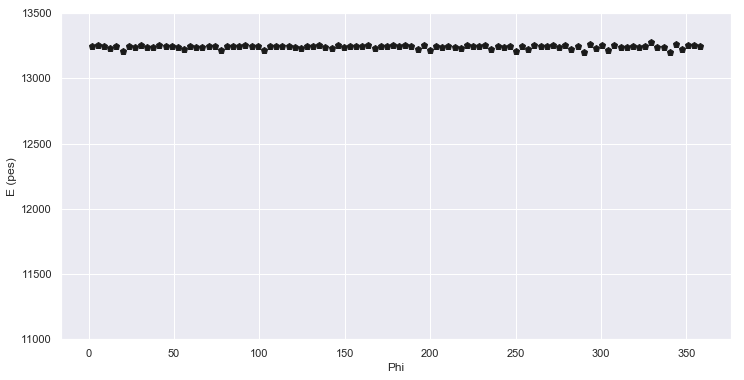

In [91]:
energy_X_profile(phirad_to_deg(dst.Phi), E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

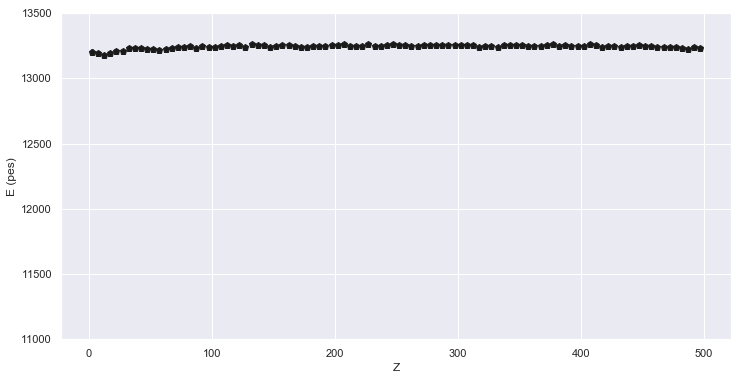

In [92]:
energy_X_profile(dst.Z, E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

# Fiducial selection R and Z

- R < 180
- 10 < z < 550
- 11000 < E < 13500

In [93]:
dst = dst.assign(E=E)

In [94]:
RFID = 175
dst_R     = dst[dst.R < RFID]

### Repeat profles

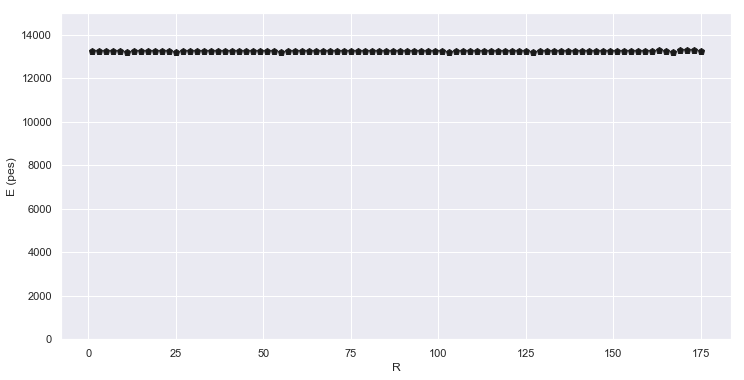

In [95]:
energy_X_profile(dst_R.R, dst_R.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

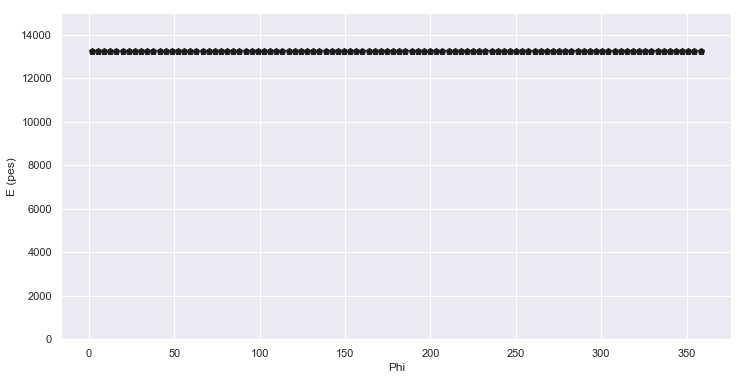

In [96]:
energy_X_profile(phirad_to_deg(dst_R.Phi), dst_R.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

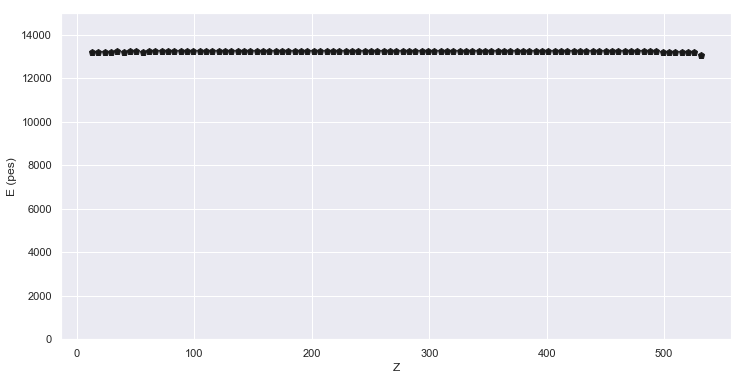

In [97]:
energy_X_profile(dst_R.Z, dst_R.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

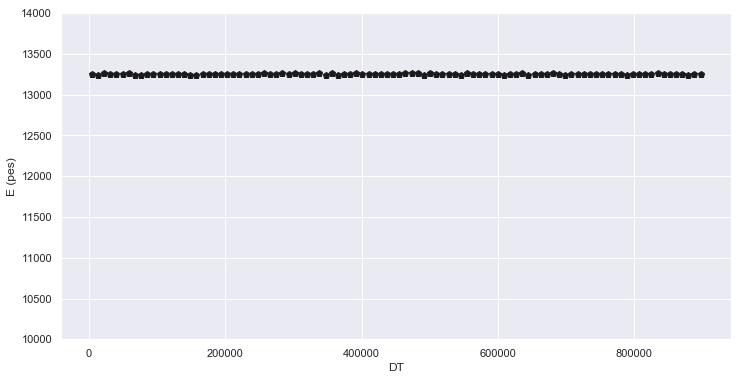

In [98]:
energy_X_profile(dst_R.DT, dst_R.E, xnbins = 100, xrange=(dst_R.DT.values[0], dst_R.DT.values[-1]), xlabel = 'DT',
                 erange=(10000,14000),   
                 figsize=(12,6))

##### Everything is flat. No need for further corrections. 

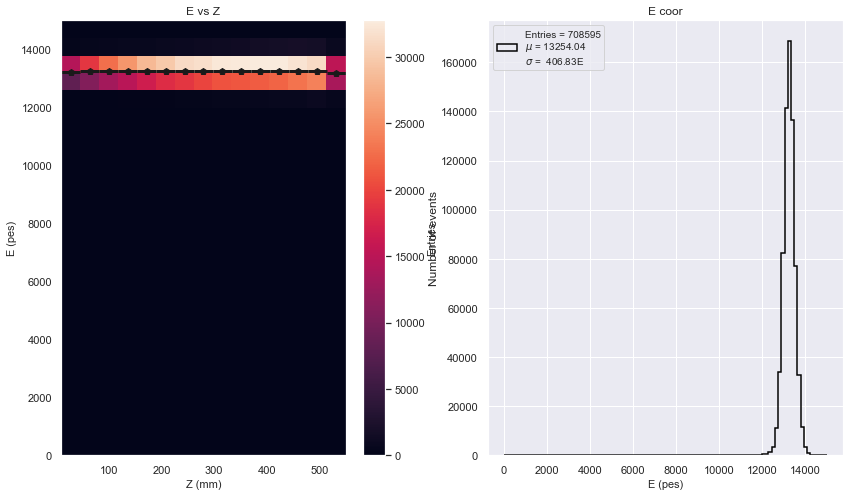

In [99]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 13270.596530687411 +-0.30487086512146827 
 E sigma   = 251.96275857914438 +-0.23553087736927286 
 chi2    = 3.951540158094829 
 sigma E/E (FWHM)     (%) =4.461837727428204
 sigma E/E (FWHM) Qbb (%) =0.5762550713871574 


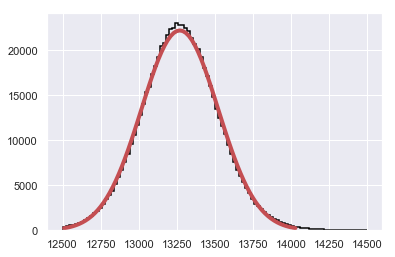

In [100]:
fc = fit_energy(dst_R.E, nbins=100, range=(12500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

# My part and that of your uncle

## Obtain Zr from extrapolating Zrms^2 vs Z linear fit

In [101]:
def z_from_s2w(s2w : np.array,  fh)->np.array:
    return (s2w * s2w - fh.values[0]) / fh.values[1]

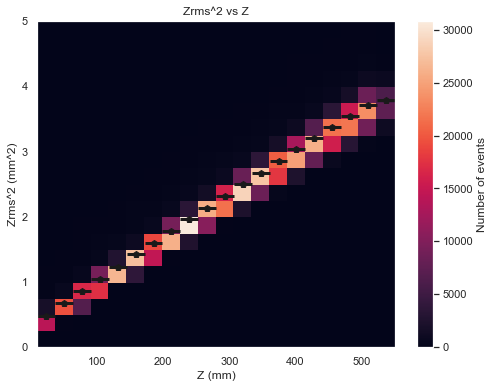

In [102]:
nevt = h2d(dst_R.Z, dst_R.Zrms*dst_R.Zrms, 20, 20, (10,550), (0, 5),
          pltLabels=PlotLabels(x='Z (mm)', y='Zrms^2 (mm^2)', title='Zrms^2 vs Z'),
          profile=True,
          figsize=(8,6))

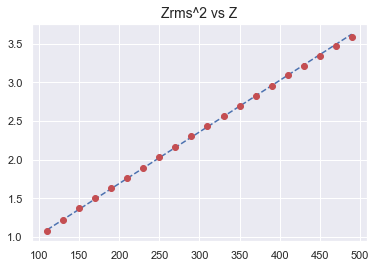

In [117]:
from krcal.core.histo_functions import profile1d
from krcal.core import fit_functions_ic as fitf

x, y, yu  = profile1d(dst_R.Z, dst_R.Zrms*dst_R.Zrms, 20, range_z=(100, 500))

fhrms     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(100,500), sigma=0.01*y)
fhrms
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fhrms.fn(x), 'b--')
plt.title('Zrms^2 vs Z', fontsize=14);

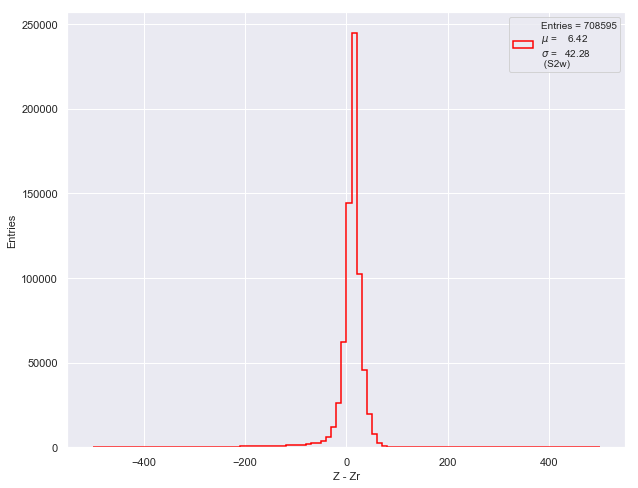

In [118]:
ZS2 = z_from_s2w(dst_R.Zrms, fhrms)
fig = plt.figure(figsize=(10,8))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst_R.Z - zr, bins=100, range = (-500,500), color='red', stats=True, lbl='\n (S2w)')
plot_histo(PlotLabels('Z - Zr','Entries',''), ax)

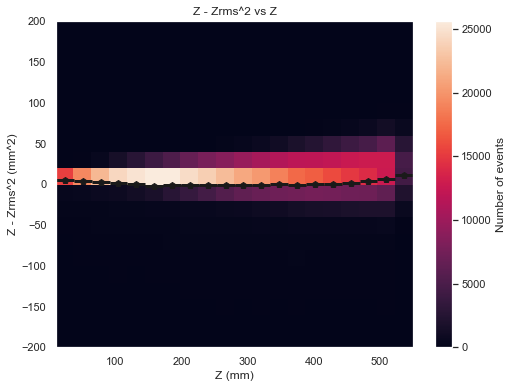

In [105]:
nevt = h2d(dst_R.Z , dst_R.Z - zr, 20, 20, (10,550), (-200, 200),
          pltLabels=PlotLabels(x='Z (mm)', y='Z - Zrms^2 (mm^2)', title='Z - Zrms^2 vs Z'),
          profile=True,
          figsize=(8,6))

### Append ZS2 column to dst

In [129]:
# dst_R.join(pd.Series(ZS2).series, on=dst_R.index)
dst_ZS2 = dst_R.assign(ZS2=pd.Series(ZS2).values)


## Compute maps using Zs2

### First divide in xy sectors

In [130]:
ti = timeit(select_xy_sectors_df)
KXY2 = ti(dst_ZS2, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 11.202650785446167 s


In [131]:
nXY2 = event_map_df(KXY2)

### Fit in XY sectors (using Zs2) 

In [132]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy_zr = ti(selection_map = KXY2,
              event_map      = nXY2,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'ZS2',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 13.539966106414795 s


### Process maps 

In [133]:
ti = timeit(tsmap_from_fmap)
tsm_zr = ti(fmxy_zr)

Time spent in tsmap_from_fmap: 0.006892204284667969 s


In [141]:
am = amap_from_tsmap(tsm_zr, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)
amap_average(rmap)
asm_zr = relative_errors(rmap)
asmAv_zr = amap_replace_nan_by_mean(asm_zr, amMean=amv)
norm_zr = amap_max(asmAv_zr)

2019-02-25 17:25:44,592 | INFO :  set nans to average value of interval = 7500.0
2019-02-25 17:25:44,676 | INFO :  set nans to average value of interval = 3500.0


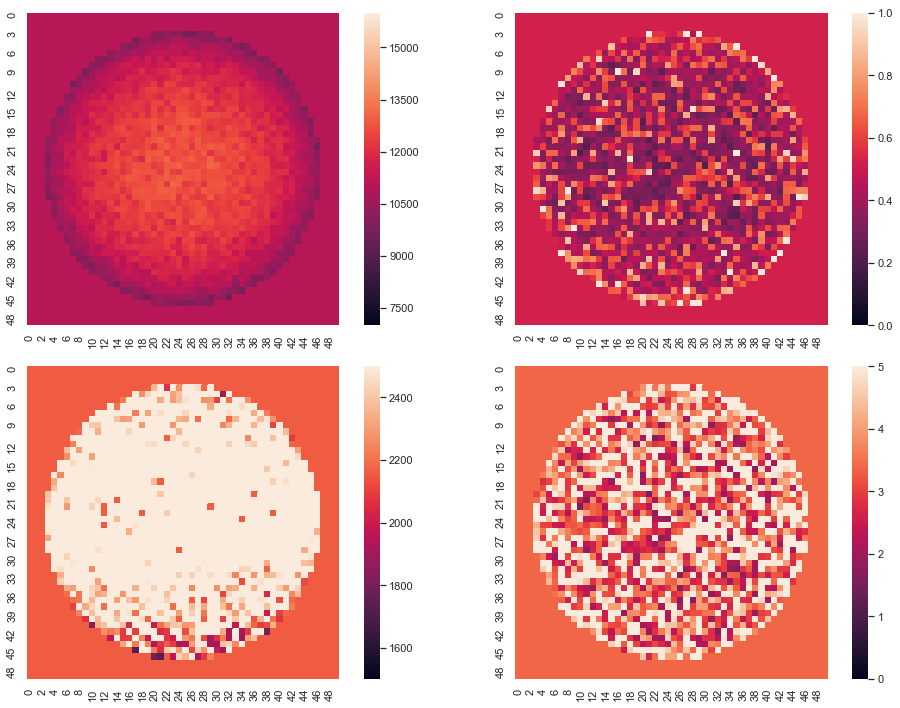

In [159]:
draw_xy_maps(asmAv_zr,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

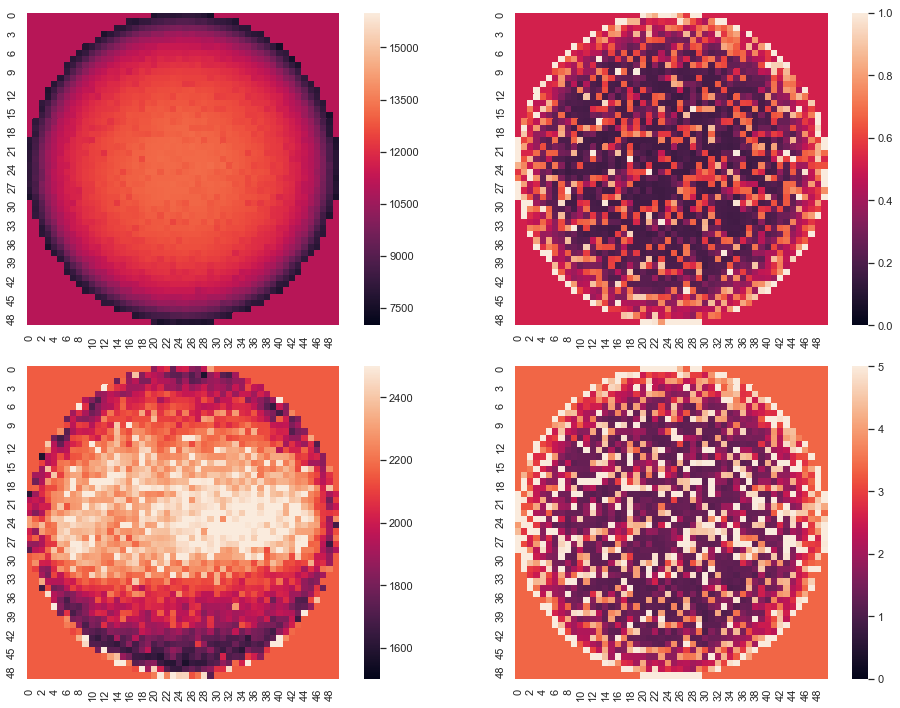

In [138]:
draw_xy_maps(asm,
            e0lims  = (7000, 16000),
            ltlims  = (1500, 2500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [157]:
type(asmAv_zr), type(asm)

(krcal.core.kr_types.ASectorMap, krcal.core.kr_types.ASectorMap)

## Correct maps for E and LT

In [144]:
ti = timeit(e0_xy_correction)
E0_zr = ti(dst_ZS2.S2e.values,
        dst_ZS2.X.values,
        dst_ZS2.Y.values,
        E0M = asmAv_zr.e0 / norm_zr.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 17.089568853378296 s


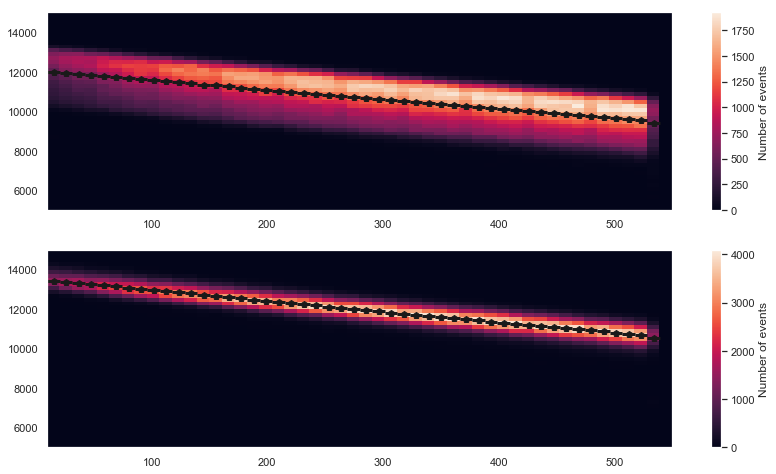

In [145]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst_ZS2.Z, dst_ZS2.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst_ZS2.Z, E0_zr, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

### XY (single time) LT correction

In [146]:
ti = timeit(lt_xy_correction)
E_zr = ti(E0_zr, 
       dst_ZS2.X.values, 
       dst_ZS2.Y.values,
       dst_ZS2.Z.values, 
       LTM = asmAv_zr.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 17.44575786590576 s


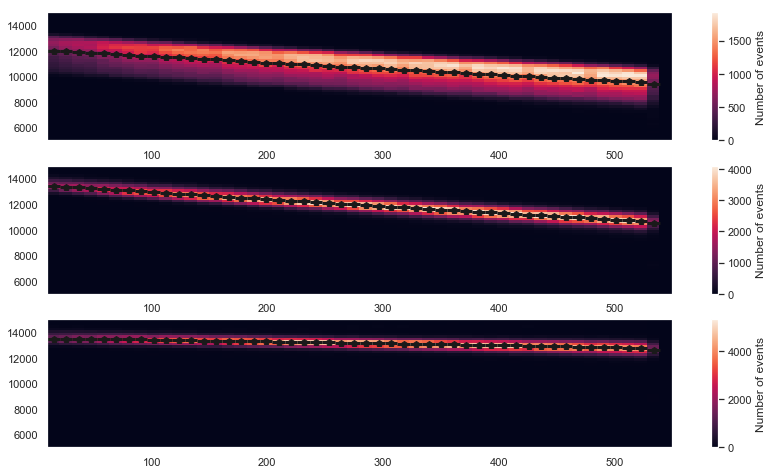

In [148]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst_ZS2.Z, dst_ZS2.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst_ZS2.Z, E0_zr, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst_ZS2.Z, E_zr, 50, 50, krRanges.Z, er, 
           profile=True)

## Compare resolution using Z and Zs2

In [149]:
dst_ZS2 = dst_ZS2.assign(E=E_zr)

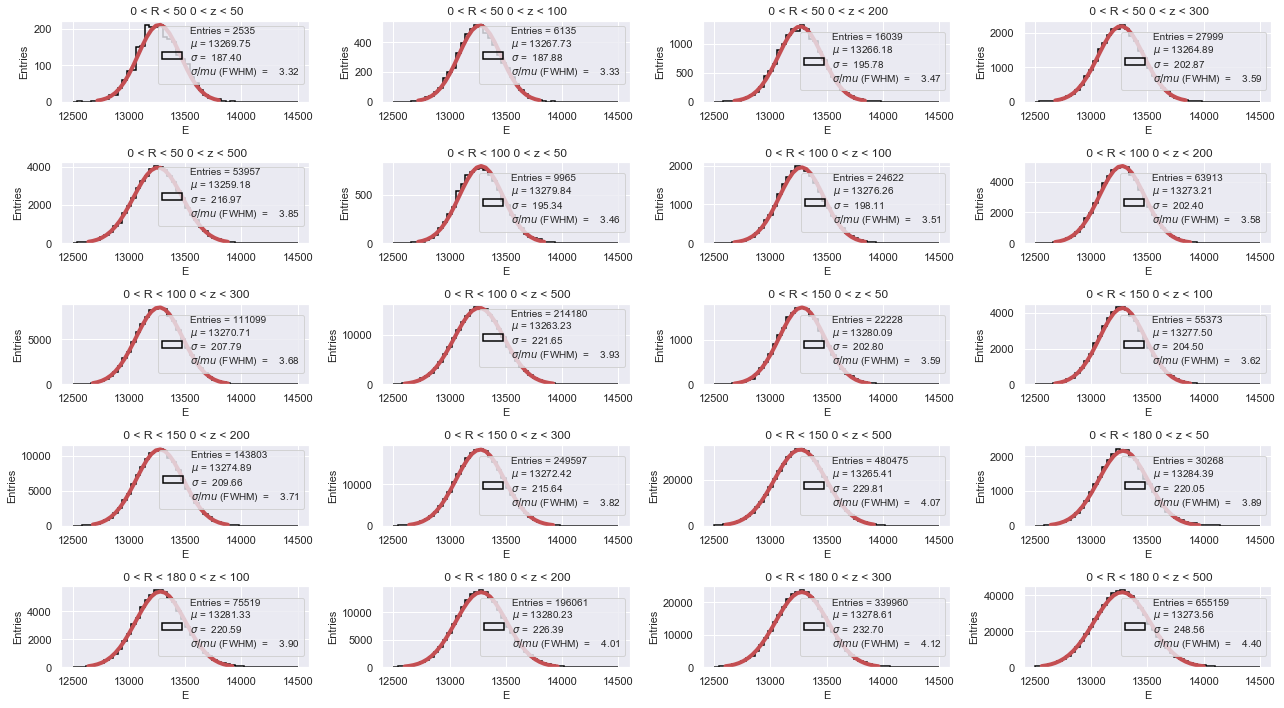

In [106]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.E,
                    enbins = 50,
                    erange = (12500,14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

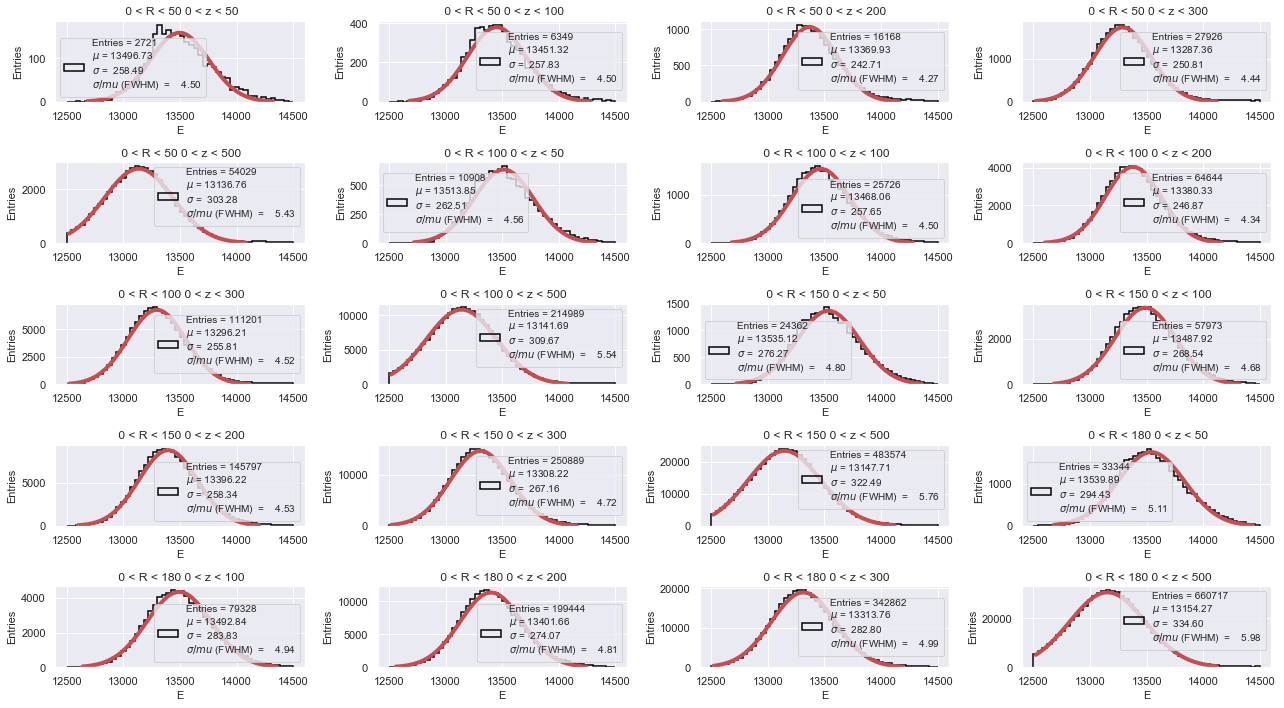

In [150]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FCr, FCEr = resolution_r_z(Ri, Zi, dst_ZS2.R, dst_ZS2.ZS2, dst_ZS2.E,
                    enbins = 50,
                    erange = (12500,14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

In [151]:
FC

,0,1,2,3
0,3.318750,3.456814,3.588766,3.892644
1,3.327828,3.506727,3.619445,3.903095
2,3.468147,3.583468,3.711520,4.006064
3,3.594058,3.679555,3.818013,4.118266
4,3.845482,3.927233,4.071160,4.400529


In [152]:
FCr

,0,1,2,3
0,4.500708,4.564954,4.796689,5.110135
1,4.504460,4.495577,4.678726,4.943311
2,4.266105,4.335831,4.531936,4.805854
3,4.435870,4.521301,4.717520,4.991660
4,5.425320,5.537584,5.764068,5.977631


In [153]:
np.average((FCr-FC).values)
np.average(FCE.values)
FCr-FC

,0,1,2,3
0,1.181958,1.108140,1.207924,1.217491
1,1.176632,0.988850,1.059281,1.040216
2,0.797957,0.752363,0.820416,0.799790
3,0.841811,0.841746,0.899507,0.873394
4,1.579838,1.610351,1.692908,1.577102


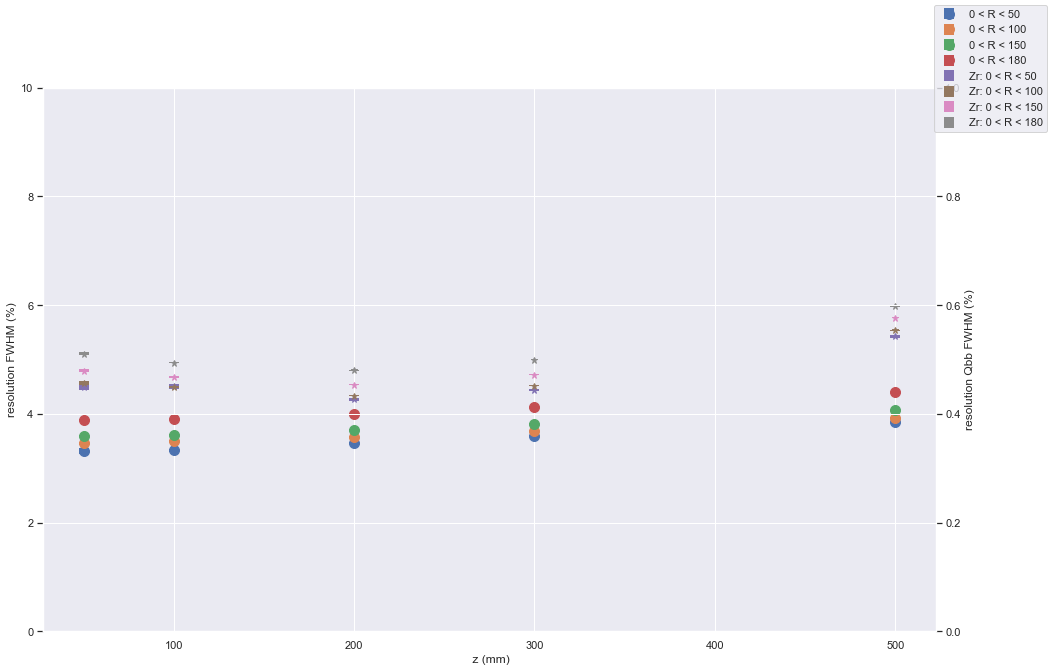

In [154]:
# plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))
def extrapolate_to_qbb(es : float)->float:
    return np.sqrt(41 / 2458) * es

def np_extrapolate_to_qbb(es : np.array)->np.array:
    return np.sqrt(41 / 2458) * es
    
r_range=(0,10)
fig       = plt.figure(figsize=(16,10))

ax  = fig.add_subplot(1, 1, 1)
ax2 = ax.twinx()
Zcenters = np.array(list(Zi))
for i in FC.columns:
    label = f'0 < R < {Ri[i]:2.0f}'

    es = FC[i].values
    eus = FCE[i].values
    qes = extrapolate_to_qbb(es)
    qeus = extrapolate_to_qbb(eus)
    ax.errorbar(Zcenters, es, eus,
                label = label,
                fmt='o', markersize=10., elinewidth=10.)
#     ax2.errorbar(Zcenters, qes, qeus,
#                 label = label,
#                 fmt='o', markersize=10., elinewidth=10.)

for i in FC.columns:
        
    label = f'Zr: 0 < R < {Ri[i]:2.0f}'
    esr = FCr[i].values
    eusr = FCEr[i].values
    qesr = extrapolate_to_qbb(es)
    qeusr = extrapolate_to_qbb(eus)
    ax.errorbar(Zcenters, esr, eusr,
                label = label,
                fmt='*', markersize=7., elinewidth=10.)
#     ax2.errorbar(Zcenters, qesr, qeusr,
#                 label = label,
#                 fmt='o', markersize=10., elinewidth=10.)
plt.grid(True)
ax.set_ylim(r_range)

ax.set_xlabel(' z (mm)')
ax.set_ylabel('resolution FWHM (%)')
ax2.set_ylabel('resolution Qbb FWHM (%)')

fig.legend()
plt.show()

# plot_resolution_r_z(Ri, Zi, FCr, FCEr, r_range=(0,10))